In [83]:
import numpy as np
import cv2

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from matplotlib import pyplot

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [74]:
import glob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
cover_fnames = sorted(glob.glob('../Cover/*.jpg'))
cover_fnames = cover_fnames[:600]
juniward_fnames = sorted(glob.glob('../JUNIWARD/*.jpg'))
juniward_fnames = juniward_fnames[:600]
jmipod_fnames = sorted(glob.glob('../JMiPOD/*.jpg'))
jmipod_fnames = jmipod_fnames[:600]
uerd_fnames = sorted(glob.glob('../UERD/*.jpg'))
uerd_fnames = uerd_fnames[:600]

In [4]:
from collections import Counter

In [5]:
print(len(cover_fnames))
print(len(juniward_fnames))
print(len(jmipod_fnames))
print(len(uerd_fnames))

600
600
600
600


In [ ]:
img = cv2.imread(uerd_fnames[0], 0)
plt.imshow(img)

In [ ]:
plt.imshow(np.flip(img, axis = 1))

In [ ]:
# from numba import jit, s

In [ ]:
x = [0,1,1,1,1,0,1,1,1,1,0]
sum_ = 0
for x_ in x:
    sum_+=x_
sum_

In [248]:
def SPAM(img, i_prime=0, j_prime=3, T=4):
    T+=1
    diff_img = []
    for i in range(0, img.shape[0], 1):
        for j in range(0, img.shape[1], 1):
            if j+j_prime<img.shape[1] and i+i_prime<img.shape[0]:
                diff = img[i][j] - img[i+i_prime][j+j_prime]
                if abs(diff) < T:
                    diff_img.append(diff)
    return np.array(diff_img)

def SPAM_Dh(img, j_prime=3, T=3):
    #Dh    
    diff = (img[:,:img.shape[1]-j_prime] - img[:, j_prime:]).ravel()
    diff = diff[np.logical_and(diff>=-T, diff<=T)]
    return diff
    
def SPAM_Dv(img, i_prime=3, T=3):
    #Dv
    diff = (img[:img.shape[0]-i_prime] - img[i_prime:]).ravel()
    diff = diff[np.logical_and(diff>=-T, diff<=T)]
    return diff

def SPAM_Dd(img, i_prime=3, j_prime=3, T=3):
    # get width
    w = img.shape[1]

    img_rav = img.ravel()

    a = img_rav[:img_rav.shape[0]-(j_prime*w+i_prime)]
    b = img_rav[j_prime*w+i_prime:]
    
    for i in range(i_prime):
        try:
            del_ = np.append(del_, np.arange(w-i-1,img_rav.shape[0]-(j_prime*w+i_prime), w))
        except:
            del_ = np.arange(w-i-1,img_rav.shape[0]-(j_prime*w+i_prime), w)
    a = np.delete(a, del_, axis=0)
    b = np.delete(b, del_, axis=0)

    diff = a - b
    diff = diff[np.logical_and(diff>=-T, diff<=T)]

    return diff

def transition_matrix(transitions, T=3):
    n = 2*T+1 #number of states

    M = np.zeros((n,n))
    
    for (i,j), c in Counter(zip(transitions, transitions[1:])).items():
        M[i][j] = c
        
    M = M/M.sum(axis=1)[:,None]
    M[np.isnan(M)] = 0
    return M    
#     #now convert to probabilities:
#     for row in M:
#         s = sum(row)
#         if s > 0:
#             row[:] = [f/s for f in row]
#     return np.array(M)

In [255]:
img = cv2.imread(cover_fnames[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
img = img.astype(int)

img_j = cv2.imread(jmipod_fnames[0])
img_j = cv2.cvtColor(img_j, cv2.COLOR_BGR2YCR_CB)
img_j = img_j.astype(int)

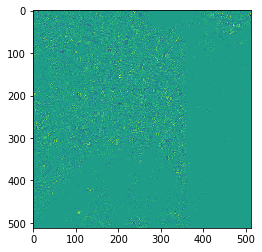

In [256]:
plt.imshow(img[:,:,0] - img_j[:,:,0])

In [257]:
a = SPAM_Dv(img, 3, 3)

In [281]:
max(Dd)

4

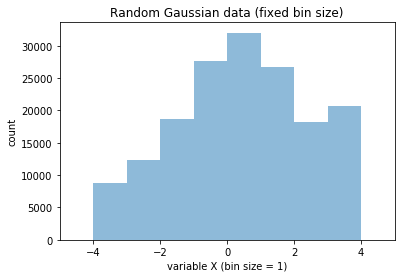

In [280]:
# img = np.flip(img, axis = 1)
cutoff = 3
T = 4
Dh =  SPAM_Dh(img, cutoff, T)
Dv =  SPAM_Dv(img, cutoff, T)

Dd =  SPAM_Dd(img, cutoff, cutoff, T)

# data = np.random.normal(0, 20, 1000) 
lim = 5
# fixed bin size
bins = np.arange(-lim, lim, 1) # fixed bin size

plt.xlim([-lim, lim])

plt.hist(Dd, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 1)')
plt.ylabel('count')

plt.show()

In [ ]:
z = Counter(zip(x, x[1:]))
for i in Counter(zip(x, x[1:])):
    print(i)
    
for k,v in z.items():
    print(v)

In [ ]:
# for (i,j), c in Counter(zip(x, x[1:])).items():
#     b[i-1,j-1] = c

In [ ]:
%timeit transition_matrix(x)

In [ ]:
x = [0,1,1,1,1,0,1,1,1,1,0]
print(transition_matrix(x))

In [285]:
T = 3
jump = 3
X_train = []
X_test = []
y_train = []
y_test = []
train_test_split_ = 500
for i, fname in enumerate(cover_fnames):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    # get the Y 
    img = img[:,:,0]
    img = img.astype(int)
    Dh_cover, Dv_cover, Dd_cover, Dm_cover = transition_matrix(SPAM_Dh(img, jump, T)+T, T), \
    transition_matrix(SPAM_Dv(img, jump, T)+T, T), transition_matrix(SPAM_Dd(img, jump, jump, T)+T, T), \
    transition_matrix(SPAM_Dd(np.flip(img, axis = 1), jump, jump, T)+T, T)
    hold = np.append(Dh_cover.ravel(), Dv_cover.ravel())
    hold = np.append(hold, Dd_cover.ravel())
    hold = np.append(hold, Dm_cover.ravel())    
    if i < train_test_split_:
        X_train.append(hold)
        y_train.append(0)
    else:
        X_test.append(hold)
        y_test.append(0)
    if i%100==0:
        print(i)
        
print('Done Covers')

# for i, fname in enumerate(juniward_fnames):
#     img = cv2.imread(fname)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
#     # get the Y 
#     img = img[:,:,0]
#     img = img.astype(int)
#     Dh_cover, Dv_cover, Dd_cover, Dm_cover = transition_matrix(SPAM_Dh(img, 0, 3, T)+T), \
#     transition_matrix(SPAM_Dv(img, 3, 0, T)+T), transition_matrix(SPAM_Dd(img, 3, 3, T)+T), \
#     transition_matrix(SPAM_Dd(np.flip(img, axis = 1), 3, 3, T)+T)
#     hold = np.append(Dh_cover.ravel(), Dv_cover.ravel())
#     hold = np.append(hold, Dd_cover.ravel())
#     hold = np.append(hold, Dm_cover.ravel())
#     if i < train_test_split_:
#         X_train.append(hold)
#         y_train.append(1)
#     else:
#         X_test.append(hold)
#         y_test.append(1)
#     if i%100==0:
#         print(i)
        
# print('Done J')
        
# for i, fname in enumerate(jmipod_fnames):
#     img = cv2.imread(fname)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
#     # get the Y 
#     img = img[:,:,0]
#     img = img.astype(int)
#     Dh_cover, Dv_cover, Dd_cover, Dm_cover = transition_matrix(SPAM_Dh(img, 0, 3, T)+T), \
#     transition_matrix(SPAM_Dv(img, 3, 0, T)+T), transition_matrix(SPAM_Dd(img, 3, 3, T)+T), \
#     transition_matrix(SPAM_Dd(np.flip(img, axis = 1), 3, 3, T)+T)
#     hold = np.append(Dh_cover.ravel(), Dv_cover.ravel())
#     hold = np.append(hold, Dd_cover.ravel())
#     hold = np.append(hold, Dm_cover.ravel())
#     if i < train_test_split_:
#         X_train.append(hold)
#         y_train.append(1)
#     else:
#         X_test.append(hold)
#         y_test.append(1)
#     if i%100==0:
#         print(i)
        
# print('Done J')
        
for i, fname in enumerate(uerd_fnames):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    # get the Y 
    img = img[:,:,0]
    img = img.astype(int)
    Dh_cover, Dv_cover, Dd_cover, Dm_cover = transition_matrix(SPAM_Dh(img, jump, T)+T, T), \
    transition_matrix(SPAM_Dv(img, jump, T)+T, T), transition_matrix(SPAM_Dd(img, jump, jump, T)+T, T), \
    transition_matrix(SPAM_Dd(np.flip(img, axis = 1), jump, jump, T)+T, T)
    hold = np.append(Dh_cover.ravel(), Dv_cover.ravel())
    hold = np.append(hold, Dd_cover.ravel())
    hold = np.append(hold, Dm_cover.ravel())
    if i < train_test_split_:
        X_train.append(hold)
        y_train.append(1)
    else:
        X_test.append(hold)
        y_test.append(1)
    if i%100==0:
        print(i)
#     print(fname)
        
print('Done U')

0
100
200
300
400
500
Done Covers
0
../UERD/00001.jpg
../UERD/00002.jpg
../UERD/00003.jpg
../UERD/00004.jpg
../UERD/00005.jpg
../UERD/00007.jpg
../UERD/00008.jpg
../UERD/00009.jpg
../UERD/00010.jpg
../UERD/00011.jpg
../UERD/00013.jpg
../UERD/00014.jpg
../UERD/00015.jpg
../UERD/00016.jpg
../UERD/00017.jpg
../UERD/00018.jpg
../UERD/00019.jpg
../UERD/00020.jpg
../UERD/00021.jpg
../UERD/00022.jpg
../UERD/00023.jpg
../UERD/00024.jpg
../UERD/00025.jpg
../UERD/00026.jpg
../UERD/00027.jpg
../UERD/00028.jpg
../UERD/00029.jpg
../UERD/00030.jpg
../UERD/00031.jpg
../UERD/00032.jpg
../UERD/00033.jpg
../UERD/00035.jpg
../UERD/00036.jpg
../UERD/00037.jpg
../UERD/00038.jpg
../UERD/00039.jpg
../UERD/00040.jpg
../UERD/00041.jpg
../UERD/00042.jpg
../UERD/00043.jpg
../UERD/00044.jpg
../UERD/00045.jpg
../UERD/00046.jpg
../UERD/00047.jpg
../UERD/00048.jpg
../UERD/00050.jpg
../UERD/00052.jpg
../UERD/00053.jpg
../UERD/00054.jpg
../UERD/00055.jpg
../UERD/00056.jpg
../UERD/00057.jpg
../UERD/00058.jpg
../UERD/00

../UERD/00492.jpg
../UERD/00493.jpg
../UERD/00494.jpg
../UERD/00495.jpg
../UERD/00496.jpg
../UERD/00497.jpg
../UERD/00498.jpg
../UERD/00499.jpg
../UERD/00500.jpg
../UERD/00501.jpg
../UERD/00503.jpg
../UERD/00504.jpg
../UERD/00505.jpg
../UERD/00506.jpg
../UERD/00507.jpg
../UERD/00508.jpg
../UERD/00509.jpg
../UERD/00510.jpg
../UERD/00511.jpg
../UERD/00512.jpg
../UERD/00513.jpg
../UERD/00514.jpg
../UERD/00515.jpg
../UERD/00516.jpg
../UERD/00517.jpg
../UERD/00518.jpg
../UERD/00519.jpg
../UERD/00520.jpg
../UERD/00521.jpg
../UERD/00522.jpg
../UERD/00524.jpg
../UERD/00525.jpg
../UERD/00526.jpg
../UERD/00527.jpg
../UERD/00529.jpg
../UERD/00530.jpg
../UERD/00531.jpg
../UERD/00533.jpg
../UERD/00534.jpg
../UERD/00535.jpg
../UERD/00536.jpg
../UERD/00537.jpg
../UERD/00538.jpg
../UERD/00539.jpg
../UERD/00540.jpg
../UERD/00541.jpg
../UERD/00542.jpg
500
../UERD/00543.jpg
../UERD/00544.jpg
../UERD/00545.jpg
../UERD/00546.jpg
../UERD/00547.jpg
../UERD/00549.jpg
../UERD/00550.jpg
../UERD/00551.jpg
../UER

44129


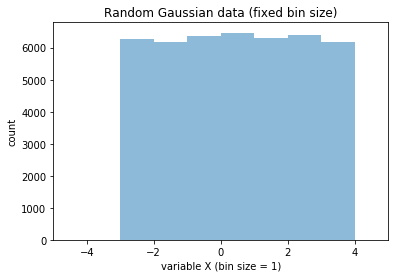

In [143]:
img_u = cv2.imread(juniward_fnames[110])
img_u = cv2.cvtColor(img_u, cv2.COLOR_BGR2YCR_CB)
# get the Y 
img_u = img_u[:,:,0]
img_u = img_u.astype(int)

Dh = SPAM_Dd(img_u, 3, 3, T)#+T
print(len(Dh))
# data = np.random.normal(0, 20, 1000) 
lim = 5
# fixed bin size
bins = np.arange(-lim, lim, 1) # fixed bin size

plt.xlim([-lim, lim])

plt.hist(Dh, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 1)')
plt.ylabel('count')

plt.show()

44157


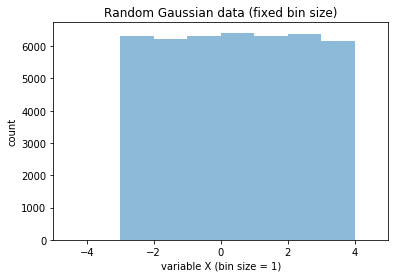

In [144]:
img_cov = cv2.imread(cover_fnames[110])
img_cov = cv2.cvtColor(img_cov, cv2.COLOR_BGR2YCR_CB)
# get the Y 
img_cov = img_cov[:,:,0]
img_cov = img_cov.astype(int)

Dh = SPAM_Dd(img_cov, 3, 3, T)#+T
print(len(Dh))
# data = np.random.normal(0, 20, 1000) 
lim = 5
# fixed bin size
bins = np.arange(-lim, lim, 1) # fixed bin size

plt.xlim([-lim, lim])

plt.hist(Dh, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 1)')
plt.ylabel('count')

plt.show()

In [ ]:
# lim = 5
# # fixed bin size
# bins = np.arange(-lim, lim, 1) # fixed bin size

# plt.xlim([-lim, lim])

# plt.hist(diff, bins=bins, alpha=0.5)
# plt.title('Random Gaussian data (fixed bin size)')
# plt.xlabel('variable X (bin size = 1)')
# plt.ylabel('count')

# plt.show()

In [ ]:
for i in range(len(X_train)):
    if X_train[i].shape[0] != 196:
        print(i)

In [ ]:
# X = np.delete(X_train, [1487, 9487], axis=0)
# y = np.delete(y_train, [1487, 9487], axis=0)

In [145]:
from sklearn import preprocessing
from sklearn.svm import SVC

In [295]:
from sklearn.utils import shuffle
X, y = X_train.copy(), y_train.copy()# shuffle(X_train, y_train, random_state=0)

In [296]:
X = list(X)
y = list(y)

In [297]:
X[2]

array([0.17232211, 0.15864776, 0.16092682, 0.14472018, 0.12902001,
       0.11876424, 0.11559889, 0.16415216, 0.15203095, 0.1521599 ,
       0.14235977, 0.13913604, 0.12740168, 0.12275951, 0.15371822,
       0.14813495, 0.14564029, 0.14991684, 0.14445236, 0.13245426,
       0.12568306, 0.13670614, 0.1393374 , 0.1516565 , 0.15321134,
       0.14471953, 0.13897859, 0.1353905 , 0.12718327, 0.12558426,
       0.15166052, 0.15362854, 0.14784748, 0.14674047, 0.14735547,
       0.11616797, 0.12333417, 0.14370128, 0.14043249, 0.15287905,
       0.16054815, 0.16293689, 0.10903388, 0.1140527 , 0.13764115,
       0.15119197, 0.14918444, 0.16060226, 0.1782936 , 0.16806471,
       0.17106052, 0.15383463, 0.14304973, 0.13211504, 0.11758538,
       0.11428999, 0.16321506, 0.15916003, 0.15597393, 0.14829833,
       0.1352643 , 0.1204924 , 0.11759594, 0.15149778, 0.15522431,
       0.15135445, 0.13931489, 0.13859825, 0.13472839, 0.12928193,
       0.13624056, 0.14507624, 0.148354  , 0.14792646, 0.14208

In [298]:
for i in range(len(X)):
    if X[i].shape[0] != 196:
        print(i)

In [299]:
# X = np.delete(X, [9231, 9530], axis=0)
# y = np.delete(y, [9231, 9530], axis=0)

In [300]:
type(X_train)

list

In [301]:
type(X)

list

In [302]:
np.array(list(X)).shape

(1000, 196)

In [303]:
# pca = PCA(n_components=12)
# pca.fit(X)
# X = pca.transform(X)

svclassifier = SVC(kernel='rbf', random_state=42, gamma=100, C=100, degree=3, probability=True)
svclassifier.fit(X, y)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [304]:
print(confusion_matrix(y, svclassifier.predict(X)))
print(classification_report(y, svclassifier.predict(X)))

[[480  20]
 [ 46 454]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       500
           1       0.96      0.91      0.93       500

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.011


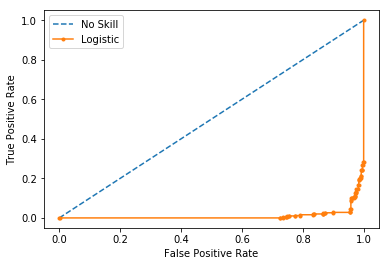

In [305]:
ns_probs = [0 for _ in range(len(y))]
# predict probabilities
lr_probs = svclassifier.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [306]:
y_pred = svclassifier.predict(X_test)

In [307]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[60 40]
 [63 37]]
              precision    recall  f1-score   support

           0       0.49      0.60      0.54       100
           1       0.48      0.37      0.42       100

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200



In [226]:
from sklearn.decomposition import PCA

In [237]:
pca = PCA(n_components=5)
fit = pca.fit(X)
# summarize components
print("Explained Variance: %s" % sum(fit.explained_variance_ratio_))
# print(fit.components_)

Explained Variance: 0.9557395739285117


In [243]:
X_pca = pca.transform(X)
svclassifier = SVC(kernel='rbf', random_state=42, gamma=100, C=10, degree=5, probability=True)
svclassifier.fit(X_pca, y)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma=100, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [244]:
print(confusion_matrix(y, svclassifier.predict(X_pca)))
print(classification_report(y, svclassifier.predict(X_pca)))

[[340 160]
 [258 242]]
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       500
           1       0.60      0.48      0.54       500

    accuracy                           0.58      1000
   macro avg       0.59      0.58      0.58      1000
weighted avg       0.59      0.58      0.58      1000



In [245]:
X_test_pca = pca.transform(X_test)
y_pred = svclassifier.predict(X_test_pca)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[65 35]
 [61 39]]
              precision    recall  f1-score   support

           0       0.52      0.65      0.58       100
           1       0.53      0.39      0.45       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.52      0.51       200



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.494


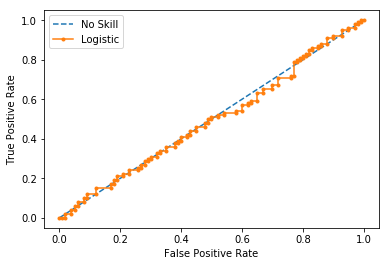

In [246]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = svclassifier.predict_proba(X_test_pca)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [67]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1000)
clf.fit(X_pca, y)

print(confusion_matrix(y,clf.predict(X_pca)))
print(classification_report(y,clf.predict(X_pca)))

y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[  12  488]
 [   0 1500]]
              precision    recall  f1-score   support

           0       1.00      0.02      0.05       500
           1       0.75      1.00      0.86      1500

    accuracy                           0.76      2000
   macro avg       0.88      0.51      0.45      2000
weighted avg       0.82      0.76      0.66      2000

[[  0 100]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.75      1.00      0.86       300

    accuracy                           0.75       400
   macro avg       0.38      0.50      0.43       400
weighted avg       0.56      0.75      0.64       400



/home/usman/.virtualenvs/YOLO/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import decomposition

In [ ]:
y_train = np.array(y_train)

In [ ]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X_train)
X = pca.transform(X_test)

# for label in [0, 1]:
#     ax.text3D(X[y_test == label, 0].mean(),
#               X[y_test == label, 1].mean() + 1.5,
#               horizontalalignment='center', s=1,
#               bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y_test, [1, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_test, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_test, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

In [ ]:
X_train = np.array(X_train)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [ ]:
model = keras.Sequential([
        keras.layers.Dense(1024, activation="relu", name="layer1"),
        keras.layers.Dense(512, activation="relu", name="layer2"),
        keras.layers.Dense(1, activation='sigmoid', name="layer3"),
    ])

In [ ]:
np.array(X).shape

In [ ]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-2, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(np.array(X), np.array(y), epochs = 100)

In [ ]:
y

In [ ]:
plt.imshow(cv2.imread(cover_fnames[3]))

In [ ]:
from jpeg2dct.numpy import load, loads


#read from a file
jpeg_file = cover_fnames[3]
dct_y, dct_cb, dct_cr = load(jpeg_file)
print ("Y component DCT shape {} and type {}".format(dct_y.shape, dct_y.dtype))
print ("Cb component DCT shape {} and type {}".format(dct_cb.shape, dct_cb.dtype))
print ("Cr component DCT shape {} and type {}".format(dct_cr.shape, dct_cr.dtype))

In [ ]:
dct_y[1][0].shape

In [ ]:
plt.imshow(dct_y[3][60].reshape(8, 8))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(-1.2, 1.2))

x = np.linspace(0, 10)
ax1.plot(np.sin(x))
ax2.plot(np.cos(x));


In [ ]:
lim = 64
fig, ax = plt.subplots(lim, lim, sharex='col', sharey='row', 
                       gridspec_kw={'hspace': 0, 'wspace': 0})

# axes are in a two-dimensional array, indexed by [row, col]
for i in range(lim):
    for j in range(lim):
        ax[i, j].imshow(dct_y[i][j].reshape(8, 8))
# fig


In [ ]:
plt.imshow(dct_y.reshape(512, 512))